# 0. Initial setup, packages installation, and loading the necessary libraries.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
PATH = '/content/drive/My Drive/Courses/FourthBrain/Week 8/Midterm Project/Option 1/'
os.chdir(PATH)

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
%matplotlib inline

from utils import *

In [17]:
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import time
import copy
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. Building a Model to Classify Retinal Disease

 > ## 1.1 Exploratory Data Analysis

In [14]:
train_df = load_data(PATH+'data/train/train.csv', ',')
print(train_df.shape)

# Let's visualize some rows of the data. The first columns corresponds to the
# image file and the rest if the image contain any of the retinal disease.
train_df.head(100)

FILE EXIST
(3435, 8)


,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
95,8518b692368f.jpg,1,1,0,1,0,0,0
96,7a3e5d2d09bc.jpg,1,1,0,1,0,0,0
97,b58ca12cea1b.jpg,1,0,0,0,0,0,0
98,698d188ddd7d.jpg,1,0,0,0,0,0,0


Let's visualize now some of the images corresponding to each retinal disease. This will help us to understand a bit better the problem at hand.

In [6]:
#img = image.load_img(PATH+'data/train/train/c6cd48bc64c8.jpg')

#cv2_imshow(cv2.imread(ORIGINAL))

# reads image 'opencv-logo.png' as grayscale
# img = cv2.imread(PATH+'data/train/train/c6cd48bc64c8.jpg') 
# plt.imshow(img)
# cv2_imshow(img)

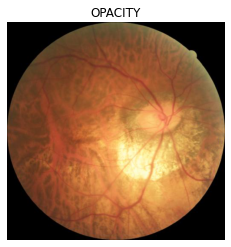

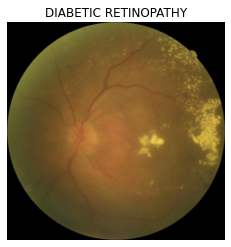

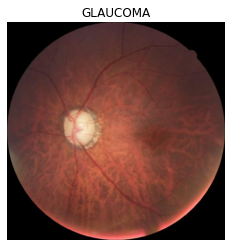

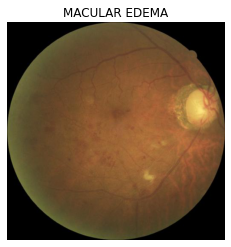

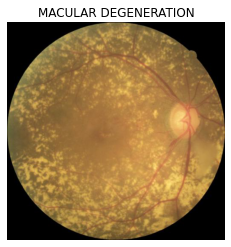

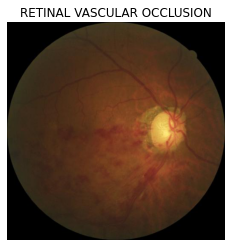

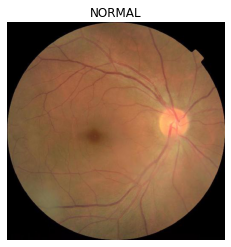

In [65]:
# Examples of retinal images correspinding to each category.
disease_labels = train_df.columns[1:]
class_names = disease_labels

for i in disease_labels:
  image_file = train_df.loc[train_df[i] == 1, 'filename'].sample().values[0]
  image = mpimg.imread(PATH+'data/train/train/'+image_file)

  plt.title(i.upper())
  plt.axis("off")
  plt.imshow(image)
  plt.show()

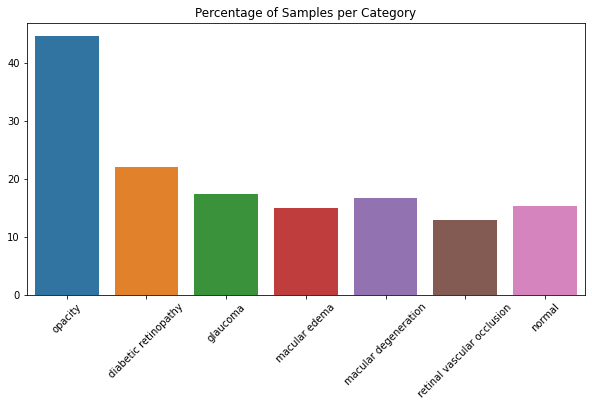

retinal vascular occlusion     440
macular edema                  516
normal                         525
macular degeneration           574
glaucoma                       597
diabetic retinopathy           755
opacity                       1533
dtype: int64


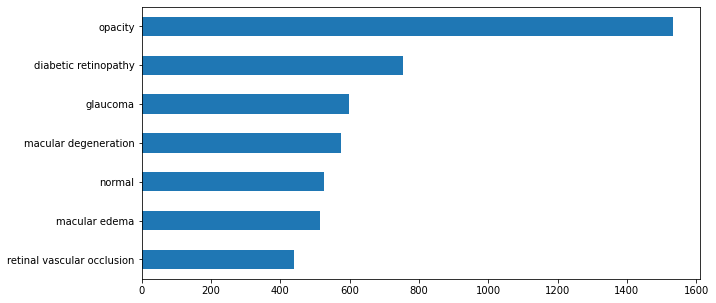

In [8]:
# Display the percentage and number of samples per disease label.
category_percentage(train_df, disease_labels)

plt.figure(figsize=(10, 5))
train_df[disease_labels].sum().sort_values().plot(kind='barh')
print(train_df[disease_labels].sum().sort_values())
plt.show()

After inspecting the previous graph it is evident that our data is imbalanced. There are for example 1000 (approx.) cases more of the label "*opacity*" compared to most of the other labels. 

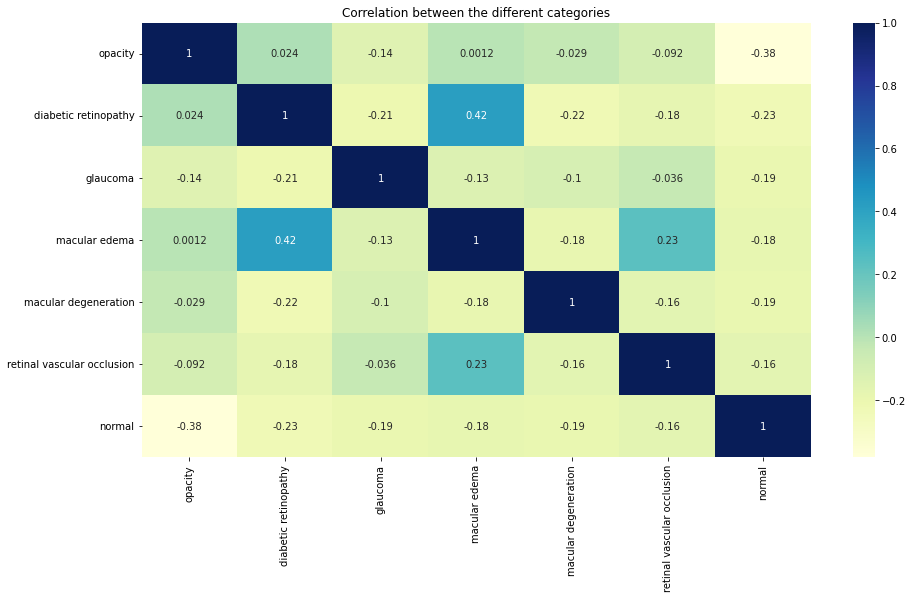

In [9]:
# Correlation between disease.
correlation_between_labels(train_df)

According to the correlation matrix, it seems there is no significant correlation between the different retinal disorders that are present in this dataset.

There is just a minor correlation  (`0.42`) between '*diabetic retinopathy*' and '*macular edema*', and (`0.23`) between '*macular edema*' and '*retinal vascular occlusion*'. Therefore, it shouln't be surprising that after training a model with this data, and when making predictions to an image with either '*diabetic retinopathy*' or '*macular edema*', then the image could get both labels.

A correlation is considered significant for values above `0.5` with a `p-value<0.05`.

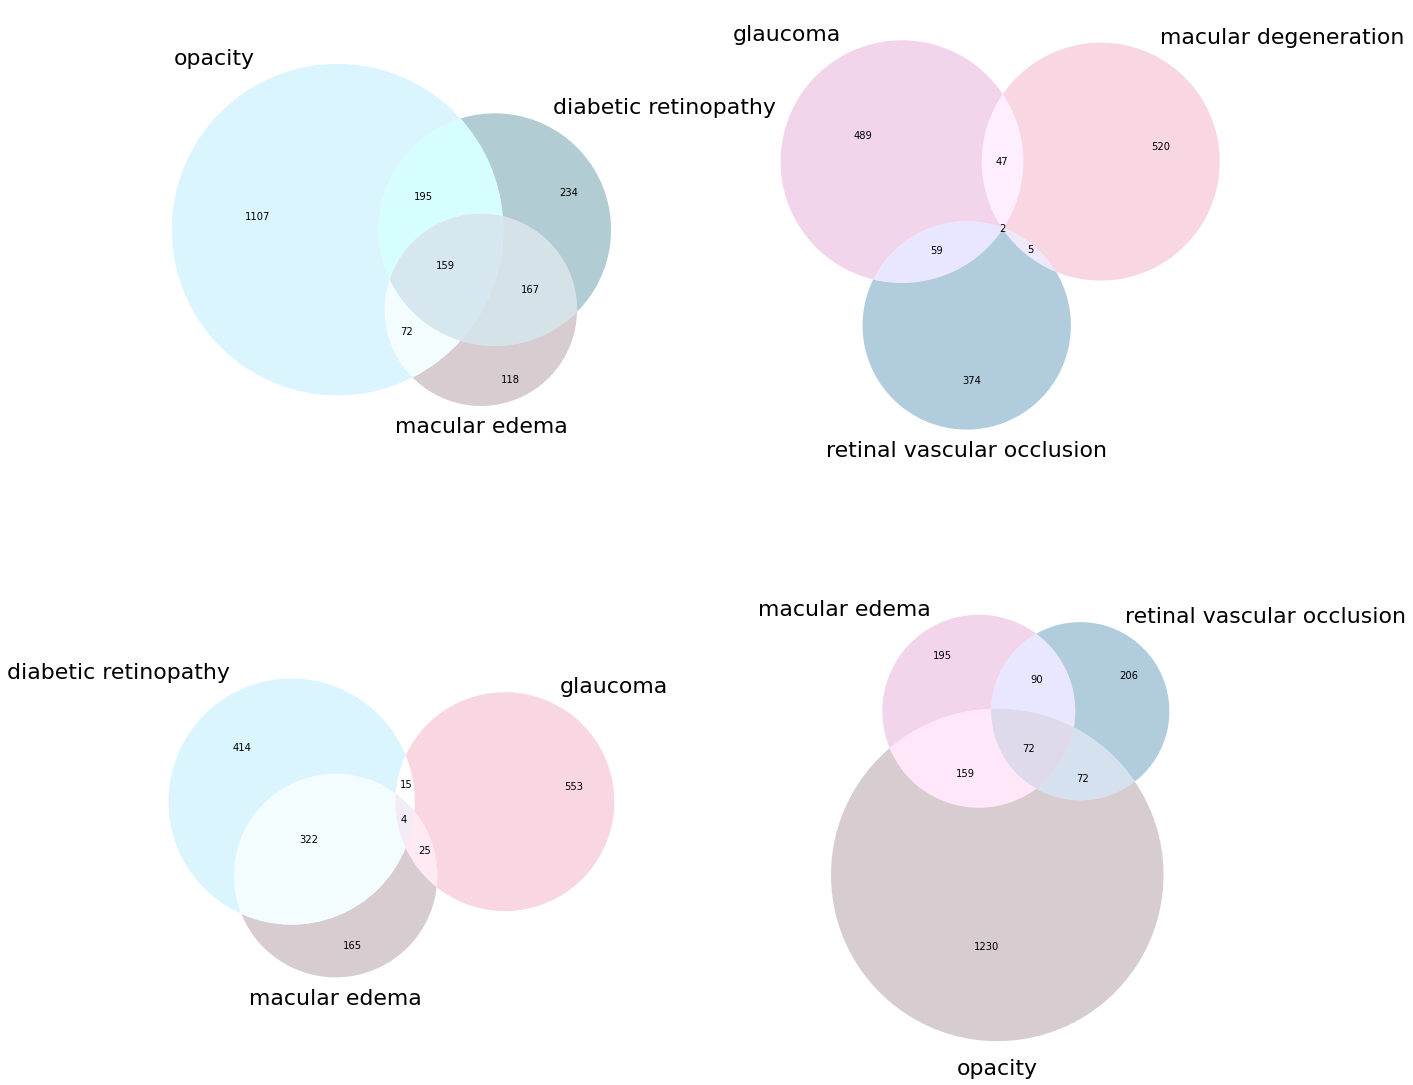

In [10]:
# Now let's explore the interrelation between categories.
venn_diagram(train_df, disease_labels, [0, 1, 3], [2, 4, 5], [1, 2, 3], [3, 5, 0])

As expected there is an overlap between the "macular edema" and the "diabetic retinopathy" disorder, and also some intersection of these two with '"opacity".

There is not much overlap between "glaucoma", "macular degeneration" and "retinal vascular occlusion".

There is also some overlap between "macular edema" and "retinal vascular oclusion".


 > ## 1.2 Setting up of a data augmentation pipeline.

In the following cell I create a the dataset class containing a set of standard image transformations:


*   `transforms.Resize(224)`: for adjusting the image size to the networks' input
*   `transforms.RandomHorizontalFlip(p=1.0)`: flip the image on the horizontal edge
*   `transforms.RandomVerticalFlip(p=1.0)`: flip the image on the vertical edge
*   `transforms.Normalize()`: Normalize a tensor image with mean and standard deviation. The numbers are coming from the ImageNet dataset (This is because I will be using models pretrained on the ImageNet dataset).  




In [22]:
# Since the dataset is not that big, I decided to incorporate more images in 
# training. Therefore, I will be using 85% of the data for training and the rest 
# for validation and just a few samples for test.

class RetinalDisorderDataset(Dataset):
    def __init__(self, img_path, df, data):
        self.img_path = img_path
        self.df = df
        self.data = data
        self.image_names = list(self.df[:]['filename'])
        self.labels = list(np.array(self.df.drop(['filename'], axis=1)))

        if data == 'train':
            print(f"Number of training images: {len(self.df)}")
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(224),
                transforms.RandomHorizontalFlip(p=1.0),
                transforms.RandomVerticalFlip(p=1.0),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        # set the validation data images and labels
        elif data == 'val':
            print(f"Number of validation images: {len(self.df)}")
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif data == 'test':
            # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(self.img_path+self.image_names[index])
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        filenames = self.image_names[index]
        return image, torch.tensor(targets, dtype=torch.float32), filenames

In [23]:
train_data, validation_data = train_test_split(train_df, train_size=0.80, random_state=42, shuffle=True)
print(train_data.shape)
print(validation_data.shape)
# Create the dataset instances and dataloaders.
batch_size = 8
# train dataset
train_dataset = RetinalDisorderDataset(
    img_path=PATH+'data/train/train/', df=train_data, data='train'
)
# validation dataset
valid_dataset = RetinalDisorderDataset(
    img_path=PATH+'data/train/train/', df=validation_data, data='val'
)

image_datasets = {
    'train': train_dataset,
    'val': valid_dataset
}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=8)
                for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

(2748, 8)
(687, 8)
Number of training images: 2748
Number of validation images: 687
cpu


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


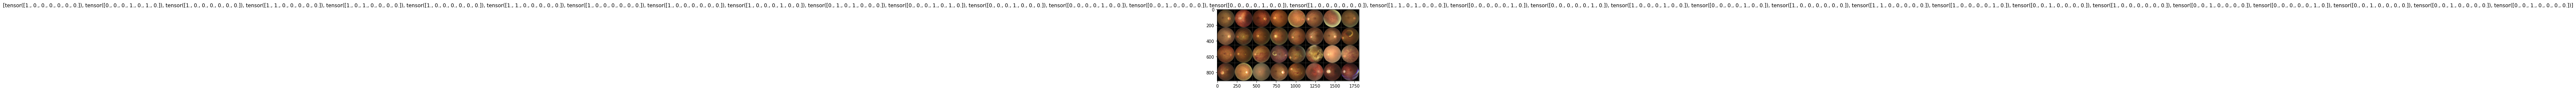

In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[x for x in classes])

# Since the "batch_size" is set to 32 then all images are shown in the graph
# below, a smaller "batch_size" would facilitate visualization in this case.

In [24]:
# Training Function 
def train_model(model, criterion, optimizer, scheduler, weights, num_epochs=25):
    since = time.time()
    weights = weights.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 0.0
    train_loss = []
    validation_loss = []


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0
            run_Acc = 0.0
            run_Prec = 0.0
            run_Rec = 0.0
            run_F1 = 0.0

            # Iterate over data.
            for idx, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                              leave=True,
                                              total=int(len(image_datasets[phase])/dataloaders[phase].batch_size)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    preds = torch.sigmoid(outputs)
                    preds = torch.round(preds)

                    loss = criterion(outputs, labels)
                    loss = (loss * weights).mean()
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                # running_corrects += torch.sum((preds == labels.data).all())

                if phase == 'val':
                    y_true, y_pred = labels.data.detach().cpu(), preds.detach().cpu()

                    run_Acc += accuracy_score(y_true, y_pred)
                    run_Prec += precision_score(y_true, y_pred, average="weighted", zero_division=0)
                    run_Rec += recall_score(y_true, y_pred, average="weighted", zero_division=0)
                    run_F1 += f1_score(y_true, y_pred, average="weighted", zero_division=0)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_acc = 100 * running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                # train_stats = '{} ==> Loss:{:.4f} Acc:{:.4f} Prec:{:.4f} Rec:{:.4f} F1:{:.4f}'.format(
                #     phase.upper(), epoch_loss, Acc_sc, Prec_sc, Rec_sc, f1_sc)
                train_stats = '{} ==> Loss:{:.4f}'.format(
                    phase.upper(), epoch_loss)
                train_loss.append(epoch_loss)
            else:
                Acc_sc = run_Acc / dataset_sizes[phase]
                Prec_sc = run_Prec / dataset_sizes[phase]
                Rec_sc = run_Rec / dataset_sizes[phase]
                f1_sc = run_F1 / dataset_sizes[phase]
                print(train_stats)
                print('{} ==> Loss:{:.4f} Acc:{:.4f} Prec:{:.4f} Rec:{:.4f} F1:{:.4f}'.format(
                    phase.upper(), epoch_loss, Acc_sc, Prec_sc, Rec_sc, f1_sc))
                validation_loss.append(epoch_loss)


            # deep copy the model
            # if phase == 'val' and epoch_acc > best_acc:
            if phase == 'val' and epoch_loss < best_loss:
                # best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), PATH + 'models/')

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, validation_loss

In [ ]:
def print_loss_history(train_loss, validation_loss, logscale=False):
    loss = train_loss
    val_loss = validation_loss
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if logscale:
        plt.yscale('log')
    plt.show()
    return

I address the imbalance characteristics of the data by calculating a weight vector corresponding to the labels, to pass it to the loss function. (See [this example](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html).)

In [15]:
def get_label_weights():
  train_labels_df = pd.DataFrame(train_dataset.labels)
  pos_weight = []
  for c in range(train_labels_df.shape[1]):
    weight = len(train_labels_df) / (train_labels_df.iloc[:, c] == 1).sum()
    pos_weight.append(weight)
  return pos_weight

For this task I'll use transfer learning. Transfer learning is increasingly used due to the availability of many pretrained models on large datasets. Additionally, since often there is not much data, and the computational resources is limited, then it is better to use transfer learning and leverage on previous work.

I will be using a pretrained ResNet50 model on the ImageNet dataset. I will freeze almost half of the model and retrain only the last 4 layers. In image classification, the features "learned" by the first layers of a model correspond to basic image features, e.g., edges, lines, simple shapes, etc. Whereas the features learned by the last layers correspond to high level features, e.g., faces, objects, etc. Therefore, it makes sense to retrain only the last layers and freeze the rest. However, it is valid to point out that this is just one approach out of a few for transfer learning.

In [25]:
lr = 0.0001
epochs = 20
model_ft = models.resnet50(pretrained=True, progress=True)

# Let's freeze the layers from 1 to 6. Then we would train only the remaining layers.
ct = 0
for child in model_ft.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

total_params = sum(p.numel() for p in model_ft.parameters())
print(f'{total_params:,} total number of parameters')
total_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} parameters to train')

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(disease_labels))

model_ft = model_ft.to(device)

criterion = nn.BCEWithLogitsLoss(reduction='none')

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft, train_loss, validation_loss = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                           weights=torch.tensor(pos_weight, dtype=torch.float32),
                           num_epochs=epochs)

25,557,032 total number of parameters
24,112,104 parameters to train
Epoch 0/19
----------


92it [00:55,  1.65it/s]
16it [00:16,  1.02s/it]

TRAIN ==> Loss:0.7935
VAL ==> Loss:16.1904 Acc:0.0001 Prec:0.0316 Rec:0.0276 F1:0.0295
Epoch 1/19
----------



92it [00:55,  1.67it/s]
16it [00:07,  2.24it/s]

TRAIN ==> Loss:0.4632
VAL ==> Loss:16.6443 Acc:0.0179 Prec:0.0316 Rec:0.0262 F1:0.0286
Epoch 2/19
----------



92it [00:54,  1.68it/s]
16it [00:07,  2.22it/s]

TRAIN ==> Loss:0.2649
VAL ==> Loss:17.3036 Acc:0.0220 Prec:0.0316 Rec:0.0259 F1:0.0284
Epoch 3/19
----------



92it [00:55,  1.66it/s]
16it [00:07,  2.20it/s]

TRAIN ==> Loss:0.1674
VAL ==> Loss:22.6002 Acc:0.0203 Prec:0.0316 Rec:0.0251 F1:0.0279
Epoch 4/19
----------



92it [00:55,  1.67it/s]
16it [00:07,  2.24it/s]

TRAIN ==> Loss:0.1065
VAL ==> Loss:28.9869 Acc:0.0213 Prec:0.0316 Rec:0.0235 F1:0.0269
Epoch 5/19
----------



92it [00:55,  1.66it/s]
16it [00:07,  2.20it/s]

TRAIN ==> Loss:0.0689
VAL ==> Loss:36.8659 Acc:0.0203 Prec:0.0316 Rec:0.0228 F1:0.0265
Epoch 6/19
----------



92it [00:55,  1.65it/s]
16it [00:07,  2.20it/s]

TRAIN ==> Loss:0.0882
VAL ==> Loss:39.1170 Acc:0.0200 Prec:0.0316 Rec:0.0220 F1:0.0259
Epoch 7/19
----------



92it [00:55,  1.65it/s]
16it [00:07,  2.18it/s]

TRAIN ==> Loss:0.0515
VAL ==> Loss:36.7180 Acc:0.0204 Prec:0.0316 Rec:0.0224 F1:0.0261
Epoch 8/19
----------



92it [00:56,  1.64it/s]
16it [00:07,  2.17it/s]

TRAIN ==> Loss:0.0340
VAL ==> Loss:35.9888 Acc:0.0208 Prec:0.0316 Rec:0.0224 F1:0.0262
Epoch 9/19
----------



92it [00:55,  1.64it/s]
16it [00:07,  2.16it/s]

TRAIN ==> Loss:0.0290
VAL ==> Loss:36.4772 Acc:0.0208 Prec:0.0316 Rec:0.0226 F1:0.0263
Epoch 10/19
----------



92it [00:55,  1.65it/s]
16it [00:07,  2.22it/s]

TRAIN ==> Loss:0.0270
VAL ==> Loss:41.6400 Acc:0.0202 Prec:0.0316 Rec:0.0217 F1:0.0257
Epoch 11/19
----------



92it [00:55,  1.65it/s]
16it [00:07,  2.19it/s]

TRAIN ==> Loss:0.0251
VAL ==> Loss:27.6346 Acc:0.0230 Prec:0.0316 Rec:0.0246 F1:0.0276
Epoch 12/19
----------



92it [00:55,  1.66it/s]
16it [00:07,  2.26it/s]

TRAIN ==> Loss:0.0216
VAL ==> Loss:25.2982 Acc:0.0234 Prec:0.0316 Rec:0.0253 F1:0.0280
Epoch 13/19
----------



92it [00:55,  1.66it/s]
16it [00:07,  2.19it/s]

TRAIN ==> Loss:0.0197
VAL ==> Loss:31.3054 Acc:0.0222 Prec:0.0316 Rec:0.0241 F1:0.0273
Epoch 14/19
----------



92it [00:55,  1.66it/s]
16it [00:07,  2.22it/s]

TRAIN ==> Loss:0.0181
VAL ==> Loss:33.4464 Acc:0.0215 Prec:0.0316 Rec:0.0236 F1:0.0270
Epoch 15/19
----------



92it [00:55,  1.67it/s]
16it [00:07,  2.23it/s]

TRAIN ==> Loss:0.0171
VAL ==> Loss:30.2950 Acc:0.0220 Prec:0.0316 Rec:0.0239 F1:0.0271
Epoch 16/19
----------



92it [00:55,  1.67it/s]
16it [00:07,  2.26it/s]

TRAIN ==> Loss:0.0173
VAL ==> Loss:29.4727 Acc:0.0223 Prec:0.0316 Rec:0.0243 F1:0.0274
Epoch 17/19
----------



92it [00:55,  1.67it/s]
16it [00:07,  2.20it/s]

TRAIN ==> Loss:0.0183
VAL ==> Loss:30.1532 Acc:0.0221 Prec:0.0316 Rec:0.0240 F1:0.0273
Epoch 18/19
----------



92it [00:55,  1.67it/s]
16it [00:07,  2.23it/s]

TRAIN ==> Loss:0.0184
VAL ==> Loss:29.4994 Acc:0.0222 Prec:0.0316 Rec:0.0242 F1:0.0273
Epoch 19/19
----------



92it [00:55,  1.66it/s]
16it [00:07,  2.23it/s]

TRAIN ==> Loss:0.0176
VAL ==> Loss:29.0844 Acc:0.0225 Prec:0.0316 Rec:0.0242 F1:0.0274
Training complete in 21m 6s
Best val Acc: 0.000000


In [ ]:
print_loss_history(train_loss, validation_loss)

I re-trained a ResNet18 and a ResNet50 network. The attached *pdf document contain the console output of the training. I was not able to train the networks on Colab (due to resources limitations). I also couldn't train the networks on the Jupyter Notebook locally. I encounter an error it seems related with multiprocesing on Jupyter. Therefore, I had to train the network in my regular IDE.

The F1_score of ResNet18 was: 0.0104. 
The F1_score of ResNet50 was: 0.0138.

Then, the ResNet50 is performing better.

In [9]:
model_rs50 = models.resnet50()
num_ftrs = model_rs50.fc.in_features
model_rs50.fc = nn.Linear(num_ftrs, 7)
model_rs50.load_state_dict(torch.load(PATH+'models/MxResNet50_v1.pth', map_location=torch.device('cpu')))
model_rs50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [45]:
from skimage import io
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

In [70]:
def gradCAM(image_source, input, model, img_scale_dim_factor, intensity=0.5):

  img = io.imread(image_source)
  dim = 500
  # resize image
  # img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  
  img_x = cv2.resize(img, (299, 299))
  # x = image.img_to_array(img_x)
  # x = np.expand_dims(x, axis=0)
  # x = preprocess_input(x)

  with torch.no_grad():
    preds = model(input)
  print(decode_predictions(preds)[0][0][1]) # prints the class of image

  with tf.GradientTape() as tape:
    last_conv_layer = model.get_layer('conv2d_93')
    iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    grads = tape.gradient(class_out, last_conv_layer)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
  heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = heatmap.reshape((8, 8))

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
  img_heatmap = heatmap * intensity + img

  # Original image vs. image plus heatmap
  cv2_imshow(img)
  cv2_imshow(img_heatmap)

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




inputs, labels, filenames = next(iter(dataloaders['train']))

for filename, input in zip(filenames, inputs):
  print(PATH+'data/train/train/'+filename)
  print(input.shape)
  gradCAM(PATH+'data/train/train/'+filename, input, model_rs50, 15)

# Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[x for x in classes])



I coulnd't make it work this task of the heatmap of the visualizations. However, I implemented it in the past for a different task. You can check [this link](https://github.com/zequeira/CNN-Activation-Heatmap/blob/main/CNN_Activation_Heatmap.ipynb).